# Chapter 8. Making Transformers Efficient in Production

## Intent Detection as a Case Study

In [9]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt, device=0)

/home/ssanchez/env/transformers/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [10]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

## Creating a Performance Benchmark

*Model performance*
How well does our model perform on a well-crafted test set that reflects production data?

*Latency*
How fast can our model deliver predictions?

*Memory*
Billion-parameter models. Especially important role in mobile or edge devices.

In [1]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT-baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        pass

    def compute_size(self):
        pass

    def time_pipeline(self):
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [2]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

In [3]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [4]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [5]:
import evaluate

accuracy_score = evaluate.load("accuracy")

/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

In [6]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [7]:
import torch
from pathlib import Path

def compute_size(self):
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate the size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [32]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 112.476
Latency (ms) - 6.120
Latency (ms) - 5.747


In [12]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    latencies = []
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [13]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Model size (MB) - 418.15
Average latency (ms) - 5.29 +\- 0.05
Accuracy on test set - 0.867


## Making Models Smaller via Knowledge Distillation

training a smaller *student* model to mimic the behavior of a slower, larger, but better-performing *teacher*.

### Knowledge Distillation for Fine-tuning

For supervised tasks like fine-tuning, the main idea is to augment the ground truth labels with a distribution of "soft probabilities" from the teacher which provide complementary information for the sudient to learn from.

### Knowledge Distillation for Pretraining

general-purpose student that can be subsequently fine-tuned on downstream tasks. The teacher is a pretrained language model ehich transfers its knowledge about masked language modleing to the student.

Let's see how we can use knowledge distillation to fine-tune a smaller and faster model. To do that we'll need a way to augment the corss-entropy loss with a Lkd term. Fortunately we can do this by **creating our own trainer**!

### Creating a Knowledge Distillation Trainer

We need to add a few things to the Trainer base class:
- The new hyperparameters alpha and T, which control the relative weight of the distillation loss and how much the probability distribution of the labels should be smoothed
- The fine-tuned teacher model, which in our casi is BERT-base
- A new loss function that combines the cross-entropy loss with the knowledge distillation loss

In [14]:
from transformers import TrainingArguments

# Adding the new hyperparameters. include them as attrbutes
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

# new loss function for the trainer itself. overriding compute_loss()
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs): # teacher model that has already been fine-tuned on our task
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # had to add **kwargs
        outputs_stu = model(**inputs)
        # Extract corss-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean") # we average the losses over the batch dimension
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1), # expects the inputs in the form of log probabilities
            F.softmax(logits_tea / self.args.temperature, dim=-1) # and the labels as normal probabilities
        )
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### Choosing a Good Student Initialization

Which pretrained languange model should we pick for the student? In general we should pick a smaller model for the student to reduce the latency and memory footprint.

A good rule of thumb from the literature is that knowledge distillation works best when the teacher and student are of the same *model type*. Different model types can have different output embedding spaces, which hinders the ability of the sudent to mimic the teacher.

In our case the teacher is BERT, so DistilBERT is a natural candidate to initialize the student with since it has 40% fewer parameters and has been shown to acheve strong results on downstream tasks.

In [16]:
from transformers import AutoTokenizer

# Tokenize and encode our queries. Instantiate DistilBERT and create a simple tokenize_text() function ot take care of the preprocessing
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"]) # we no longer need text column
clinc_enc = clinc_enc.rename_column("intent", "labels") # so it can be automatically detected by the trainer

In [16]:
from huggingface_hub import notebook_login
notebook_login()

In [17]:
# define compute_metrics() for our DistillationTrainer
def compute_metrics(pred):
    preds, labels = pred
    preds = np.argmax(preds, axis=1)
    return accuracy_score.compute(predictions=preds, references=labels)

In [18]:
# Define training argumemnts
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy="epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1,
    weight_decay=0.01, push_to_hub=True
)

/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
from transformers import AutoConfig
# initialize a student model

id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

num_labels = intents.num_classes
student_config = (AutoConfig.
                 from_pretrained(student_ckpt,
                                num_labels=num_labels,
                                id2label=id2label,
                                label2id=label2id))

In [20]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device))

In [21]:
# Load the teacher and fine-tune
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                .from_pretrained(teacher_ckpt,
                                num_labels=num_labels)
                .to(device))

distilbert_trainer = DistillationTrainer(model_init=student_init,
                                        teacher_model=teacher_model, args=student_training_args,
                                        train_dataset=clinc_enc["train"],
                                        eval_dataset=clinc_enc["validation"],
                                        compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

/tmp/ipykernel_1349230/3053386859.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if p

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.320341,0.717097
2,3.820000,1.912013,0.853871
3,3.820000,1.193916,0.889677
4,1.739800,0.889615,0.912258
5,0.937600,0.804199,0.917097


TrainOutput(global_step=1590, training_loss=2.0883489740719585, metrics={'train_runtime': 113.0215, 'train_samples_per_second': 674.65, 'train_steps_per_second': 14.068, 'total_flos': 414689637990180.0, 'train_loss': 2.0883489740719585, 'epoch': 5.0})

It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfAp

The 92% accuracy on the validation set looks quite good compared to the 94% that the BERT-base teacher achieves.

In [22]:
distilbert_trainer.push_to_hub("Training completed!")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/sergi24sanchez/distilbert-base-uncased-finetuned-clinc/commit/ce294051719361819bcacad60974dc2bf8f6c0a2', commit_message='Training completed!', commit_description='', oid='ce294051719361819bcacad60974dc2bf8f6c0a2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergi24sanchez/distilbert-base-uncased-finetuned-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='sergi24sanchez/distilbert-base-uncased-finetuned-clinc'), pr_revision=None, pr_num=None)

In [33]:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt, device=0)

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [34]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 3.11 +\- 0.46
Accuracy on test set - 0.858


To compare these results against our baseline, let's create a scatter plot of the accyracy against the latency, with the radius of each point corresponding to the size of the model on disk.

/tmp/ipykernel_1399227/2626924658.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


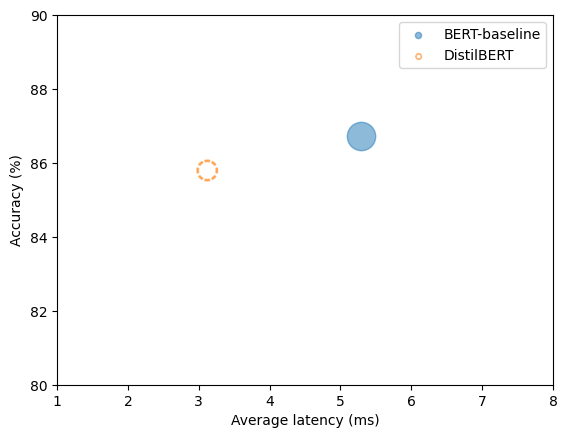

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
            alpha=0.5, s=df_opt["size_mb"], label=idx, marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
            alpha=0.5, s=df_opt["size_mb"], label=idx)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT-baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

From the plot we can see that by using a smaller model we've managed to significantly decrease the average latency. And all this at the price of just 1% reduction in accuracy!

Let's see if we can close that last gap by including the distillation loss of the teacher and finding good values for alpha and T.

### Finding Good Hyperparameters with Optuna

To find good values of alpha and T we could do a grid search over the 2D parameter space. But a much better alternative is to *Optuna*, which is an optimization framework designed for just this type of task.

Optuna formulates the search problem in therms of an objesctive function that is oprimized though mutliple *trials*. We can dinf the minimum of $f(x,y)$ by defining an *objective()* function that returns the value of $f(x,y)$

In [36]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2) # suggest_float specifies the parameter ranges to sample uniformly from
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [37]:
# Optuna collects multiple trials as a *study*, so to create one we just pass the *objective()* function to study.optimize()
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2025-06-17 13:59:45,603] A new study created in memory with name: no-name-b95f7f30-6e1c-4761-b127-3876be165693
[I 2025-06-17 13:59:45,604] Trial 0 finished with value: 88.0855368235617 and parameters: {'x': -0.7494109551075359, 'y': -0.3604737697888436}. Best is trial 0 with value: 88.0855368235617.
[I 2025-06-17 13:59:45,605] Trial 1 finished with value: 21.44088564258775 and parameters: {'x': -1.4811197953412933, 'y': 1.8027563847319894}. Best is trial 1 with value: 21.44088564258775.
[I 2025-06-17 13:59:45,606] Trial 2 finished with value: 108.95132171920034 and parameters: {'x': 1.2962200083306938, 'y': 0.6368092188841961}. Best is trial 1 with value: 21.44088564258775.
[I 2025-06-17 13:59:45,607] Trial 3 finished with value: 119.76123880263073 and parameters: {'x': -0.696539327512947, 'y': -0.5959573480479969}. Best is trial 1 with value: 21.44088564258775.
[I 2025-06-17 13:59:45,608] Trial 4 finished with value: 1781.3049791835833 and parameters: {'x': -1.6959067386317157, 'y'

In [38]:
study.best_params

{'x': 1.010916402769129, 'y': 1.0193976380242071}

To use Optuna in Transformers, we use similar logic by first defining the hyperparameter space that we wish to optimize over.

In [32]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
           "alpha": trial.suggest_float("alpha", 0, 1),
           "temperature": trial.suggest_int("temperature", 2, 20)}

Running the hyperparameter search with the Trainer is then quite simple

In [33]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space
)

[I 2025-06-17 10:40:58,516] A new study created in memory with name: no-name-fd0025b1-cec5-45b5-99f7-66e4d94c75aa
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇██
eval/loss,█▄▂▁▁
eval/runtime,▁███▃
eval/samples_per_second,█▁▁▁▆
eval/steps_per_second,█▁▁▁▆
train/epoch,▁▂▃▅▅▆███
train/global_step,▁▂▃▄▅▆███
train/grad_norm,█▅▁
train/learning_rate,█▄▁
train/loss,█▃▁
eval/accuracy,0.9171


wandb: Currently logged in as: sergi-sanchez-bonilla to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.194458,0.572903
2,0.310200,0.098307,0.815484
3,0.310200,0.067867,0.872903
4,0.113200,0.053797,0.890000
5,0.075300,0.045944,0.898710
6,0.075300,0.042042,0.907419
7,0.062400,0.040844,0.907097


[I 2025-06-17 10:43:27,896] Trial 0 finished with value: 0.9070967741935484 and parameters: {'num_train_epochs': 7, 'alpha': 0.2102456437728586, 'temperature': 18.484731451118364}. Best is trial 0 with value: 0.9070967741935484.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇████
eval/loss,█▄▂▂▁▁▁
eval/runtime,▁▃▃▃█▆▄
eval/samples_per_second,█▆▆▆▁▃▅
eval/steps_per_second,█▆▆▆▁▃▅
train/epoch,▁▂▂▃▄▅▅▆▇▇██
train/global_step,▁▂▂▃▄▅▅▆▇▇██
train/grad_norm,█▇▂▁
train/learning_rate,█▆▃▁
train/loss,█▂▁▁
eval/accuracy,0.9071


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.227921,0.605484
2,0.363900,0.106886,0.836774
3,0.363900,0.068952,0.882581
4,0.124200,0.052041,0.897419
5,0.077000,0.042658,0.910323
6,0.077000,0.037699,0.919032
7,0.060900,0.035463,0.919677
8,0.054400,0.034425,0.920323


[I 2025-06-17 10:46:11,830] Trial 1 finished with value: 0.9203225806451613 and parameters: {'num_train_epochs': 8, 'alpha': 0.13856176911849827, 'temperature': 5.351581177838879}. Best is trial 1 with value: 0.9203225806451613.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇████
eval/loss,█▄▂▂▁▁▁▁
eval/runtime,▁▄▂▂█▄▄▂
eval/samples_per_second,█▅▆▇▁▅▅▇
eval/steps_per_second,█▅▆▇▁▅▅▇
train/epoch,▁▂▂▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▅▅▆▆▇███
train/grad_norm,█▇▃▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.92032


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.257896,0.606452
2,0.401700,0.125522,0.826452
3,0.401700,0.084854,0.870645
4,0.145200,0.068789,0.884839
5,0.098900,0.063905,0.889355


[I 2025-06-17 10:48:07,831] Trial 2 finished with value: 0.8893548387096775 and parameters: {'num_train_epochs': 5, 'alpha': 0.5596358751872399, 'temperature': 4.147935406801489}. Best is trial 1 with value: 0.9203225806451613.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆███
eval/loss,█▃▂▁▁
eval/runtime,▁█▅▄▃
eval/samples_per_second,█▁▄▅▆
eval/steps_per_second,█▁▄▅▆
train/epoch,▁▂▃▅▅▆███
train/global_step,▁▂▃▄▅▆███
train/grad_norm,█▆▁
train/learning_rate,█▄▁
train/loss,█▂▁
eval/accuracy,0.88935


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.261305,0.625806
2,0.416000,0.114829,0.842903
3,0.416000,0.070232,0.885806
4,0.134000,0.051794,0.901935
5,0.079200,0.042083,0.915806
6,0.079200,0.037146,0.920323
7,0.061800,0.034920,0.921935
8,0.055000,0.033939,0.923548


[I 2025-06-17 10:50:56,016] Trial 3 finished with value: 0.9235483870967742 and parameters: {'num_train_epochs': 8, 'alpha': 0.33239373328215194, 'temperature': 3.6504011372983163}. Best is trial 3 with value: 0.9235483870967742.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇████
eval/loss,█▃▂▂▁▁▁▁
eval/runtime,▁▃█▄▄█▅▅
eval/samples_per_second,█▆▁▅▅▁▄▄
eval/steps_per_second,█▆▁▅▅▁▄▄
train/epoch,▁▂▂▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▅▅▆▆▇███
train/grad_norm,█▇▃▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▁▁▁
eval/accuracy,0.92355


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.212569,0.576129
2,0.333000,0.110757,0.804839
3,0.333000,0.079108,0.863871
4,0.127300,0.066093,0.876452
5,0.091000,0.062012,0.881290


[I 2025-06-17 10:52:55,472] Trial 4 finished with value: 0.8812903225806452 and parameters: {'num_train_epochs': 5, 'alpha': 0.40235295744847954, 'temperature': 9.445985531103101}. Best is trial 3 with value: 0.9235483870967742.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆███
eval/loss,█▃▂▁▁
eval/runtime,▁▂█▃▃
eval/samples_per_second,█▇▁▅▆
eval/steps_per_second,█▇▁▅▆
train/epoch,▁▂▃▅▅▆███
train/global_step,▁▂▃▄▅▆███
train/grad_norm,█▆▁
train/learning_rate,█▄▁
train/loss,█▂▁
eval/accuracy,0.88129


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.229805,0.616774
2,0.368700,0.105601,0.840000
3,0.368700,0.066927,0.884839
4,0.123000,0.049841,0.899032
5,0.074600,0.040213,0.913226
6,0.074600,0.035127,0.921935
7,0.057900,0.032423,0.922581
8,0.050400,0.030656,0.926774
9,0.050400,0.030109,0.926774


[I 2025-06-17 10:55:53,543] Trial 5 finished with value: 0.9267741935483871 and parameters: {'num_train_epochs': 9, 'alpha': 0.7044024278776422, 'temperature': 5.040806279835347}. Best is trial 5 with value: 0.9267741935483871.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇█████
eval/loss,█▄▂▂▁▁▁▁▁
eval/runtime,▁▁▄█▂▅▂▃▇
eval/samples_per_second,█▇▄▁▇▄▇▆▂
eval/steps_per_second,█▇▄▁▇▄▇▆▂
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇██
train/grad_norm,█▇▃▁▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.92677


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.329301,0.657419
2,0.522800,0.125319,0.847742
3,0.522800,0.069007,0.893226
4,0.147100,0.049658,0.908710
5,0.078600,0.040406,0.920645
6,0.078600,0.035829,0.926774
7,0.059800,0.033208,0.930000
8,0.052200,0.031643,0.930645
9,0.052200,0.031165,0.930000


[I 2025-06-17 10:58:54,875] Trial 6 finished with value: 0.93 and parameters: {'num_train_epochs': 9, 'alpha': 0.0963785264260546, 'temperature': 2.495762911696806}. Best is trial 6 with value: 0.93.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇█████
eval/loss,█▃▂▁▁▁▁▁▁
eval/runtime,▁▂▄▂▃▆▄▃█
eval/samples_per_second,█▇▅▇▆▃▅▆▁
eval/steps_per_second,█▇▅▇▆▃▅▆▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇██
train/grad_norm,█▆▂▁▁
train/learning_rate,█▆▅▃▁
train/loss,█▂▁▁▁
eval/accuracy,0.93


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.210728,0.592903


[I 2025-06-17 10:59:13,200] Trial 7 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.5929
eval/loss,0.21073
eval/runtime,1.3908
eval/samples_per_second,2228.885


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.211926,0.595484


[I 2025-06-17 10:59:31,518] Trial 8 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.59548
eval/loss,0.21193
eval/runtime,1.4024
eval/samples_per_second,2210.559


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.196542,0.587419


[I 2025-06-17 10:59:49,840] Trial 9 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.58742
eval/loss,0.19654
eval/runtime,1.4001
eval/samples_per_second,2214.106


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.194249,0.586129


[I 2025-06-17 11:00:08,241] Trial 10 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.58613
eval/loss,0.19425
eval/runtime,1.408
eval/samples_per_second,2201.677


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.341994,0.664839
2,0.544500,0.125292,0.848387
3,0.544500,0.067447,0.893871
4,0.147400,0.048515,0.913226
5,0.076800,0.039433,0.922903
6,0.076800,0.035086,0.928065
7,0.057900,0.032172,0.931290
8,0.050000,0.030478,0.934516
9,0.050000,0.029570,0.931935
10,0.046300,0.029130,0.932581


[I 2025-06-17 11:03:13,007] Trial 11 finished with value: 0.9325806451612904 and parameters: {'num_train_epochs': 10, 'alpha': 0.6257487282434875, 'temperature': 2.3644717298298623}. Best is trial 11 with value: 0.9325806451612904.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇██████
eval/loss,█▃▂▁▁▁▁▁▁▁
eval/runtime,▁▂▇▃▂▂▂▂▂█
eval/samples_per_second,█▇▂▆▇▇▇▇▇▁
eval/steps_per_second,█▇▂▆▇▇▇▇▇▁
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,█▆▂▁▁▁
train/learning_rate,█▇▅▄▂▁
train/loss,█▂▁▁▁▁
eval/accuracy,0.93258


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.307654,0.654194
2,0.491500,0.119699,0.851290
3,0.491500,0.066869,0.893226
4,0.140600,0.048029,0.908387
5,0.075900,0.038680,0.920968
6,0.075900,0.034142,0.926774
7,0.057300,0.031244,0.930968
8,0.049300,0.029547,0.932903
9,0.049300,0.028609,0.932581
10,0.045700,0.028165,0.932581


[I 2025-06-17 11:06:02,300] Trial 12 finished with value: 0.9325806451612904 and parameters: {'num_train_epochs': 10, 'alpha': 0.5696480041396725, 'temperature': 2.6974274451501774}. Best is trial 11 with value: 0.9325806451612904.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇██████
eval/loss,█▃▂▁▁▁▁▁▁▁
eval/runtime,▁▁▂▅▂▂▂█▄▂
eval/samples_per_second,█▇▇▄▇▇▇▁▅▇
eval/steps_per_second,█▇▇▄▇▇▇▁▅▇
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,█▆▂▁▁▁
train/learning_rate,█▇▅▄▂▁
train/loss,█▂▁▁▁▁
eval/accuracy,0.93258


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.404953,0.673548
2,0.639600,0.137456,0.845161
3,0.639600,0.070388,0.897097
4,0.160900,0.050710,0.915161
5,0.079300,0.041634,0.924516
6,0.079300,0.037329,0.928710
7,0.059600,0.034281,0.931935
8,0.051500,0.032505,0.934839
9,0.051500,0.031597,0.933548
10,0.047800,0.031156,0.932903


[I 2025-06-17 11:08:59,631] Trial 13 finished with value: 0.9329032258064516 and parameters: {'num_train_epochs': 10, 'alpha': 0.584342469918365, 'temperature': 2.002000458384341}. Best is trial 13 with value: 0.9329032258064516.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇██████
eval/loss,█▃▂▁▁▁▁▁▁▁
eval/runtime,▁▂▂▇▆▁▂▃█▃
eval/samples_per_second,█▇▇▂▃█▇▆▁▆
eval/steps_per_second,█▇▇▂▃█▇▆▁▆
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,█▅▂▁▁▁
train/learning_rate,█▇▅▄▂▁
train/loss,█▂▁▁▁▁
eval/accuracy,0.9329


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.190411,0.580968


[I 2025-06-17 11:09:18,069] Trial 14 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.58097
eval/loss,0.19041
eval/runtime,1.4131
eval/samples_per_second,2193.685


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.219394,0.590000


[I 2025-06-17 11:09:36,789] Trial 15 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.59
eval/loss,0.21939
eval/runtime,1.4133
eval/samples_per_second,2193.389


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.192399,0.581290


[I 2025-06-17 11:09:55,163] Trial 16 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.58129
eval/loss,0.1924
eval/runtime,1.4122
eval/samples_per_second,2195.214


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.201256,0.588387


[I 2025-06-17 11:10:13,567] Trial 17 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.58839
eval/loss,0.20126
eval/runtime,1.4113
eval/samples_per_second,2196.574


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.400071,0.667097
2,0.623900,0.147547,0.835484


[I 2025-06-17 11:10:49,834] Trial 18 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▅█
train/global_step,▁▅█
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.83548


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.219547,0.605484


[I 2025-06-17 11:11:08,373] Trial 19 pruned. 


In [34]:
print(best_run)

BestRun(run_id='13', objective=0.9329032258064516, hyperparameters={'num_train_epochs': 10, 'alpha': 0.584342469918365, 'temperature': 2.002000458384341}, run_summary=None)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/537M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 11 LFS files:   0%|          | 0/11 [00:00<?, ?it/s]

optimizer.pt:   0%|          | 0.00/537M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/537M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/537M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

In [36]:
# Let's update our training arguments with these values and run the final training run
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
                                    teacher_model=teacher_model, args=student_training_args,
                                    train_dataset=clinc_enc["train"],
                                    eval_dataset=clinc_enc["validation"],
                                    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

/tmp/ipykernel_1349230/3053386859.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.we

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.098601,0.724839
2,2.488300,1.078710,0.863548
3,2.488300,0.615800,0.911935
4,0.964100,0.442281,0.932581
5,0.433500,0.377309,0.938387
6,0.433500,0.352347,0.942581
7,0.294000,0.337622,0.944194
8,0.248400,0.329750,0.945484
9,0.248400,0.326323,0.943548
10,0.232200,0.324946,0.944194


**Remarkably, we've been able to train the student to match the accuracy of the teacher, despite it having almost half the number of parameters!**

In [37]:
distil_trainer.push_to_hub("Training Completed!")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sergi24sanchez/distilbert-base-uncased-distilled-clinc/commit/c0ff1085e2c724737da7359285dda7aca942311e', commit_message='Training Completed!', commit_description='', oid='c0ff1085e2c724737da7359285dda7aca942311e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergi24sanchez/distilbert-base-uncased-distilled-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='sergi24sanchez/distilbert-base-uncased-distilled-clinc'), pr_revision=None, pr_num=None)

### Benchmarking Our Distilled Model

In [39]:
distilled_ckpt = "sergi24sanchez/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt, device=0)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 2.86 +\- 0.06
Accuracy on test set - 0.882


/tmp/ipykernel_1399227/2626924658.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


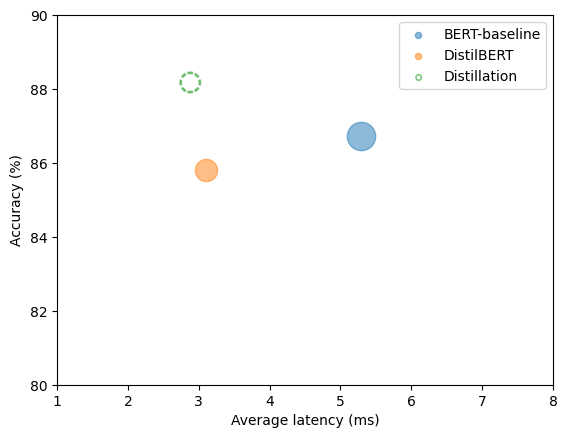

In [40]:
plot_metrics(perf_metrics, optim_type)

The model size and latency remain essentially unchanged compared to DistilBERT benchmark, but the accuracy has improved and even surpassed the performance of the teacher!!!
One way to interpret this, is that the teacher has likely no tbeen fine-tuned as systematically as the student.

This is great, but we can actually compress our distilled model even further using a technique known as quantization.

## Making Models Faster with Quantization



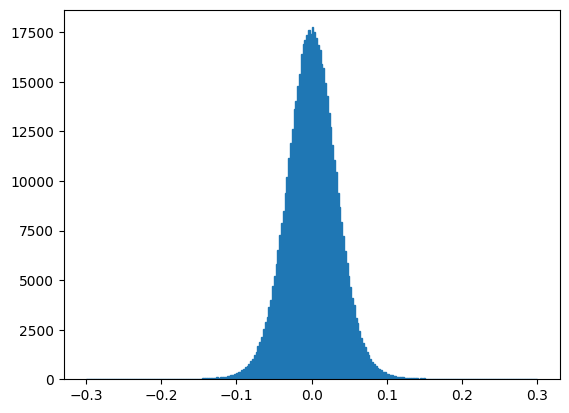

In [42]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().cpu().numpy(), bins=250, range=(-0.3, 0.3), edgecolor="C0")
plt.show()

In [43]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

to obtain the quantized tensor, we just need to invert the mapping $q = f/s + Z$, clamp de values, round them to the nearest integer, and represent the result in the *torch.int8* data type using the Tensor.char()

In [44]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   6,  -4],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  1,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], device='cuda:0',
       dtype=torch.int8)

In [47]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   6,  -4],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  1,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], device='cuda:0',
       dtype=torch.int8)

In [53]:
# For the quanitzed tensors we need the QFunctional wrapper class
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [55]:
q_fn.mul(quantized_weights.cpu(), quantized_weights.cpu())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], size=(768, 768), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=1.0, zero_point=0)